# Data

- where do we draw a line between smoothing and linking?
    - sub 10GeV
    - 3-5cm cone

- need a step in between CLUE3D output and simulation

In [1]:
import uproot
import awkward as ak
import numpy as np

import matplotlib.pyplot as plt

from reco.plotting import plot_event, plot_tracksters
from reco.energy import get_total_energy, get_energy_map
from reco.evaluation import bcubed, f_score
from reco.event import get_trackster_map, get_bary, get_lc
from reco.matching import get_highest_energy_fraction_simtracksters

# %matplotlib widget
%matplotlib inline

file_name = "~/Data/multi/new_ntuples_14992862_996.root"

tracksters = uproot.open({file_name: "ticlNtuplizer/tracksters"})
simtracksters = uproot.open({file_name: "ticlNtuplizer/simtrackstersSC"})
graphs = uproot.open({file_name: "ticlNtuplizer/graph"})
associations = uproot.open({file_name: "ticlNtuplizer/associations"})

E_TH = 10

## Dataset preparation

Identify sub-10Gev tracksters

In [2]:
tenergy = ak.flatten(tracksters["raw_energy"].array())
stenergy = ak.flatten(simtracksters["stsSC_raw_energy"].array())

we have much two orders of magnitude more lareclusters in the sub 10 GeV range

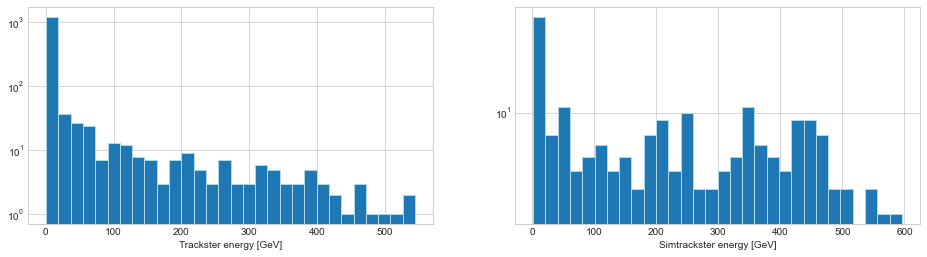

In [3]:
fig = plt.figure(figsize=(16, 4))
plt.style.use('seaborn-whitegrid')
ax = fig.add_subplot(121)
ax.hist(tenergy, bins=30, edgecolor="lightblue")
ax.set_yscale("log")
ax.set_xlabel("Trackster energy [GeV]")
ax = fig.add_subplot(122)
ax.set_xlabel("Simtrackster energy [GeV]")
ax.hist(stenergy, bins=30, edgecolor="lightblue")
ax.set_yscale("log")
plt.show()

In [4]:
e_distances = []
e_pairs = []

raw_es = tracksters["raw_energy"].array()
for eid in range(len(raw_es)):
    bary = get_bary(tracksters, eid)
    raw_e = raw_es[eid]
    large_tracksters = np.where(raw_e > E_TH)[0]
    tiny_tracksters = np.where(raw_e <= E_TH)[0]
    reco_fr, reco_st = get_highest_energy_fraction_simtracksters(tracksters, simtracksters, associations, eid)

    pairs = []
    distances = []

    for tt_id in tiny_tracksters:
        max_st = reco_st[tt_id]
        
        # large tracksters of the same particle
        # could be precomputed
        same_particle_tracksters = np.where(np.array(reco_st) == max_st)
        large_spt = np.intersect1d(same_particle_tracksters, large_tracksters)
        
        # compute distances (todo: better distance metric needed)
        dists = list([np.linalg.norm(bary[tt_id] - bary[lsp]) for lsp in large_spt])
        if dists:
            distances.append(min(dists))
            pairs.append([tt_id, large_spt[np.argmin(dists)]])
    e_pairs.append(pairs)
    e_distances.append(distances)

sub-10GeV tracksters distance from nearest large trackster from the same particle distribution

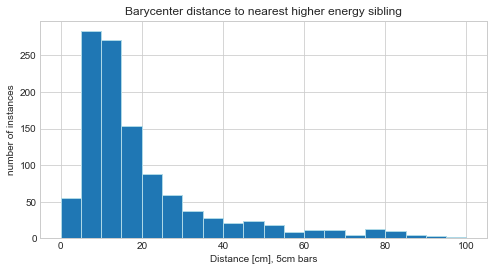

In [6]:
fig = plt.figure(figsize=(8, 4))
plt.style.use('seaborn-whitegrid')
ax = fig.add_subplot(111)
ax.hist(ak.flatten(e_distances), bins=20, edgecolor="lightblue", range=(0,100))
ax.set_title("Barycenter distance to nearest higher energy sibling")
ax.set_xlabel("Distance [cm], 5cm bars")
ax.set_ylabel("number of instances")
plt.show()

14.458967


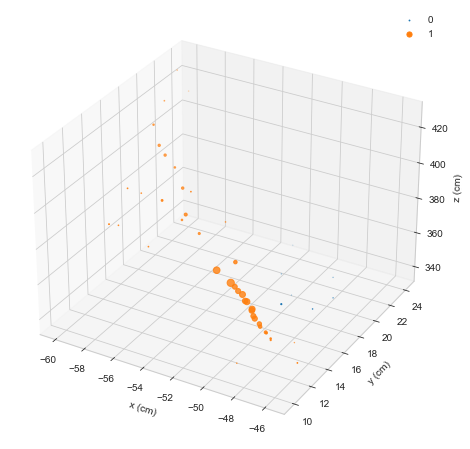

In [6]:
eid = 0
x_lc = tracksters["vertices_x"].array()[eid]
y_lc = tracksters["vertices_y"].array()[eid]
z_lc = tracksters["vertices_z"].array()[eid]
e_lc = tracksters["vertices_energy"].array()[eid]

p_id = 5
p = e_pairs[eid][p_id]
d = e_distances[eid][p_id]
print(d)

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

plot_tracksters(ax, x_lc[p], y_lc[p], z_lc[p], e_lc[p])
plt.legend()
plt.show()